# **Loading HSI in python**

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Initialize an empty list to store the image data
image_data_list = []

# Loop through the images and convert them to NumPy arrays
for i in range(31):
  # Construct the file name for the current image
  image_file = f'/content/drive/MyDrive/balloons_ms/balloons_ms/balloons_ms_{i+1:02d}.png'

  # Open the image and convert it to a NumPy array
  image = Image.open(image_file)
  image_data = np.array(image)

  # Append the image data to the list
  image_data_list.append(image_data)

# Stack the image data into a 3D array
image_data = np.stack(image_data_list, axis=2)


In [ ]:
image_data.shape

(512, 512, 31)

# **GROUND TRUTH DATASET.**

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers

gt_data=[]

for j in range(15):

  for i in range(15):
    if j==0 & i==0:
      gt_dataset=image_data[0:63,0:63,0:31]

  # Extract a ROI from the image
    gt_dataset=image_data[j*32:j*32+64,i*32:i*32+64,0:31]
    gt_data.append(gt_dataset)
# Stack the image data into a 3D array
gt_dataset = np.stack(gt_data, axis=2)
for i in range(15):

  for j in range(15):
    if j==0 & i==0:
      gt_dataset=image_data[0:63,0:63,0:31]

  # Extract a ROI from the image
    gt_dataset=image_data[j*32:j*32+64,i*32:i*32+64,0:31]
    gt_data.append(gt_dataset)
# Stack the image data into a 3D array
gt_dataset = np.stack(gt_data, axis=2)


In [ ]:
gt_dataset.shape

(64, 64, 450, 31)

In [ ]:
image_transposed = np.transpose(gt_dataset, (2, 0, 1, 3))

In [ ]:
image_transposed.shape

(450, 64, 64, 31)

In [ ]:
image_transposed[1].shape

(64, 64, 31)

# **HI RESOLUTION RGB**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layer
input_layer = layers.Input(shape=(64, 64, 31))

# Define the convolutional layer
conv_layer = layers.Conv2D(3, kernel_size=3, padding='same', activation='relu')(input_layer)

# Define the model
model = tf.keras.Model(input_layer, conv_layer)

# Compile the model
HR_RGB = model.predict(image_transposed)

15/15 [==============================] - 7s 9ms/step


In [ ]:
HR_RGB.shape

(450, 64, 64, 3)

In [ ]:
HR_RGB[0].shape

(64, 64, 3)

# **LOW RESOLUTION HYPERSPECTRAL IMAGES**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layer
input_layer = layers.Input(shape=(64, 64, 31))

# Define the convolutional layer
conv_layer = layers.Conv2D(31, kernel_size=3, strides=8, padding='same', activation='relu')(input_layer)

# Define the model
model = tf.keras.Model(input_layer, conv_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
LRHSI = model.predict(image_transposed)

15/15 [==============================] - 0s 8ms/step


In [ ]:
LRHSI.shape

(450, 8, 8, 31)

In [ ]:
LRHSI[0].shape


(8, 8, 31)

# **IMAGE FUSION FOR SUPER RESOLUTION**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

upsample1 = layers.UpSampling2D(size=1)(input_layer1)

# Define the convolutional layer
conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample1)


# Define the convolutional layer
#conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(input_layer1)

upsample = layers.UpSampling2D(size=8)(input_layer2)

# Define the convolutional layer
conv_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample)


# Define the output layer
output_layer = layers.Add()([conv_layer1, conv_layer2 ])

# Define the model
model = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model and store the history object
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=100, batch_size=None, validation_split=0.2)



Epoch 1/100
12/12 [==============================] - 2s 44ms/step - loss: 2542473.2500 - accuracy: 0.0115 - val_loss: 1892466.5000 - val_accuracy: 0.0015
Epoch 2/100
12/12 [==============================] - 0s 22ms/step - loss: 2240559.0000 - accuracy: 0.0116 - val_loss: 1720148.7500 - val_accuracy: 0.0011
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 1984776.3750 - accuracy: 0.0111 - val_loss: 1638991.2500 - val_accuracy: 0.0018
Epoch 4/100
12/12 [==============================] - 0s 22ms/step - loss: 1874429.3750 - accuracy: 0.0121 - val_loss: 1580870.6250 - val_accuracy: 0.0024
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 1762667.0000 - accuracy: 0.0141 - val_loss: 1493018.2500 - val_accuracy: 0.0079
Epoch 6/100
12/12 [==============================] - 0s 22ms/step - loss: 1601231.6250 - accuracy: 0.0150 - val_loss: 1390369.1250 - val_accuracy: 0.0145
Epoch 7/100
12/12 [==============================] - 0s 20ms/step - loss: 15

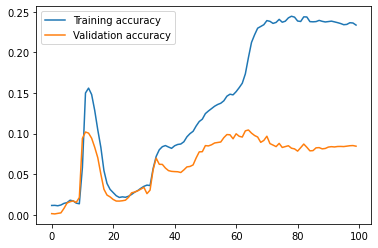

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')

plt.legend()
plt.show()

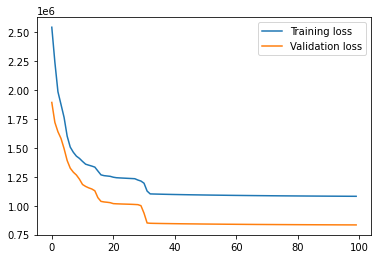

In [ ]:

# Plot and loss values

plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
upsample1 = layers.UpSampling2D(size=1)(input_layer1)
# Define the convolutional layer
conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample1)
# Define the convolutional layer
#conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(input_layer1)
upsample = layers.UpSampling2D(size=8)(input_layer2)
# Define the convolutional layer
conv_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample)
# Define the output layer
output_layer1 = layers.Add()([conv_layer1, conv_layer2 ])
# Add another convolutional layer
conv_layer3 = layers.Conv2D(64, kernel_size=1, activation='relu')(output_layer1)
# Add a pooling layer
pooling_layer2 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer3)
conv_layer4 = layers.Conv2D(128, kernel_size=1, activation='relu')(pooling_layer2)
# Add a pooling layer
pooling_layer3 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer4)
conv_layer5 = layers.Conv2D(64, kernel_size=1, activation='relu')(pooling_layer3)
# Add a pooling layer
pooling_layer4 = layers.MaxPooling2D(pool_size=(1, 1))(conv_layer5)
# Add another convolutional layer
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pooling_layer4)
# Define the model
model = tf.keras.Model([input_layer1, input_layer2], output_layer)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import matplotlib.pyplot as plt

# Train the model and store the history object
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=100, batch_size=None, validation_split=0.2)


Epoch 1/100
12/12 [==============================] - 2s 73ms/step - loss: 2694248.2500 - accuracy: 0.0832 - val_loss: 1799654.8750 - val_accuracy: 7.5955e-05
Epoch 2/100
12/12 [==============================] - 0s 38ms/step - loss: 2403498.2500 - accuracy: 0.0299 - val_loss: 1794909.3750 - val_accuracy: 1.9260e-04
Epoch 3/100
12/12 [==============================] - 0s 37ms/step - loss: 2215745.5000 - accuracy: 0.0293 - val_loss: 1587437.8750 - val_accuracy: 4.9913e-04
Epoch 4/100
12/12 [==============================] - 0s 37ms/step - loss: 2039682.5000 - accuracy: 0.0032 - val_loss: 1519706.6250 - val_accuracy: 4.1775e-04
Epoch 5/100
12/12 [==============================] - 0s 37ms/step - loss: 1924913.6250 - accuracy: 0.0036 - val_loss: 1511062.7500 - val_accuracy: 0.0189
Epoch 6/100
12/12 [==============================] - 0s 36ms/step - loss: 1834232.0000 - accuracy: 0.0302 - val_loss: 1435861.1250 - val_accuracy: 0.2818
Epoch 7/100
12/12 [==============================] - 0s 36ms

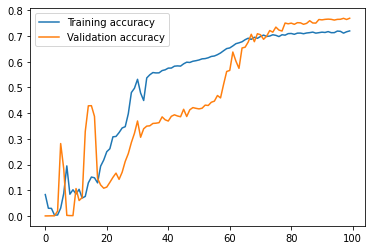

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.show()


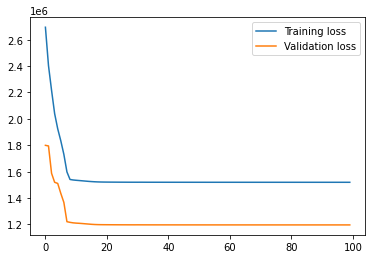

In [ ]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
# Fuse the low-resolution and high-resolution images
fused_image = model.predict([HR_RGB, LRHSI])

8/8 [==============================] - 0s 22ms/step


In [ ]:
fused_image.shape

(225, 64, 64, 31)

In [ ]:
LOSS=(fused_image-image_transposed)**2
er=LOSS.sum()
print(er/8126464)

175172637.04516962


# **new model with increase layers**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='relu')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='relu')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])


In [ ]:
import matplotlib.pyplot as plt

# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=100, batch_size=None, validation_split=0.1)

Epoch 1/100
13/13 [==============================] - 1s 71ms/step - loss: 142208352.0000 - accuracy: 0.0468 - val_loss: 58516296.0000 - val_accuracy: 0.0013
Epoch 2/100
13/13 [==============================] - 0s 31ms/step - loss: 86685496.0000 - accuracy: 0.0080 - val_loss: 32101614.0000 - val_accuracy: 0.0000e+00
Epoch 3/100
13/13 [==============================] - 0s 30ms/step - loss: 62379016.0000 - accuracy: 0.0224 - val_loss: 25412734.0000 - val_accuracy: 0.0268
Epoch 4/100
13/13 [==============================] - 0s 30ms/step - loss: 48759816.0000 - accuracy: 0.0446 - val_loss: 21330036.0000 - val_accuracy: 0.4983
Epoch 5/100
13/13 [==============================] - 0s 30ms/step - loss: 43902380.0000 - accuracy: 0.1609 - val_loss: 20733304.0000 - val_accuracy: 0.0090
Epoch 6/100
13/13 [==============================] - 0s 32ms/step - loss: 40953572.0000 - accuracy: 0.0949 - val_loss: 19304502.0000 - val_accuracy: 0.0166
Epoch 7/100
13/13 [==============================] - 0s 31m

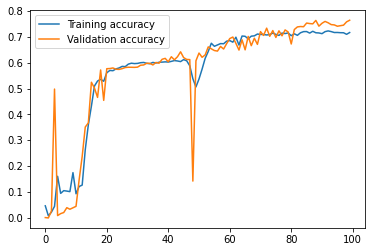

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.show()


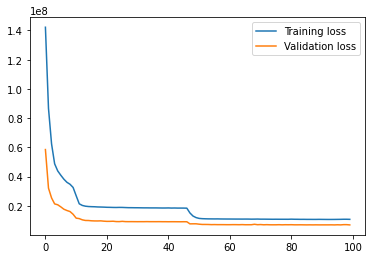

In [ ]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='relu')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='relu')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='RMSprop',
loss='mean_squared_error',
metrics=['accuracy'])


In [ ]:


# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=100, batch_size=None, validation_split=0.1)

Epoch 1/100
13/13 [==============================] - 1s 50ms/step - loss: 92153680.0000 - accuracy: 0.1341 - val_loss: 23489660.0000 - val_accuracy: 0.4945
Epoch 2/100
13/13 [==============================] - 0s 31ms/step - loss: 41739296.0000 - accuracy: 0.3647 - val_loss: 22305724.0000 - val_accuracy: 0.1087
Epoch 3/100
13/13 [==============================] - 0s 31ms/step - loss: 37036480.0000 - accuracy: 0.2480 - val_loss: 21723776.0000 - val_accuracy: 0.4460
Epoch 4/100
13/13 [==============================] - 0s 31ms/step - loss: 35652832.0000 - accuracy: 0.1755 - val_loss: 20229470.0000 - val_accuracy: 0.0611
Epoch 5/100
13/13 [==============================] - 0s 31ms/step - loss: 33846192.0000 - accuracy: 0.1378 - val_loss: 20560540.0000 - val_accuracy: 0.4251
Epoch 6/100
13/13 [==============================] - 0s 32ms/step - loss: 34327312.0000 - accuracy: 0.1170 - val_loss: 18753850.0000 - val_accuracy: 0.0262
Epoch 7/100
13/13 [==============================] - 0s 31ms/ste

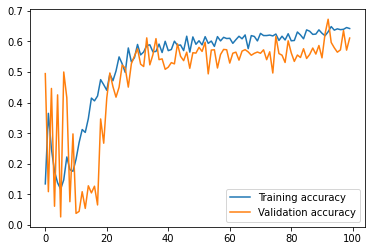

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()


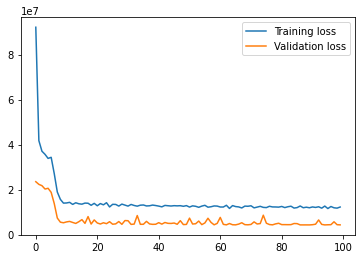

In [ ]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='relu')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='relu')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='Adam',
loss='mean_squared_error',
metrics=['accuracy'])


# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=100, batch_size=None, validation_split=0.1)

Epoch 1/100
13/13 [==============================] - 1s 51ms/step - loss: 154032512.0000 - accuracy: 0.0032 - val_loss: 52259056.0000 - val_accuracy: 0.0064
Epoch 2/100
13/13 [==============================] - 0s 34ms/step - loss: 87456920.0000 - accuracy: 0.0585 - val_loss: 39287740.0000 - val_accuracy: 4.3403e-05
Epoch 3/100
13/13 [==============================] - 0s 32ms/step - loss: 69971616.0000 - accuracy: 0.0082 - val_loss: 30560444.0000 - val_accuracy: 0.3184
Epoch 4/100
13/13 [==============================] - 0s 32ms/step - loss: 59580152.0000 - accuracy: 0.1488 - val_loss: 24190998.0000 - val_accuracy: 0.4862
Epoch 5/100
13/13 [==============================] - 0s 31ms/step - loss: 49810084.0000 - accuracy: 0.2471 - val_loss: 18102960.0000 - val_accuracy: 0.4520
Epoch 6/100
13/13 [==============================] - 0s 31ms/step - loss: 40429848.0000 - accuracy: 0.1817 - val_loss: 13918150.0000 - val_accuracy: 0.4845
Epoch 7/100
13/13 [==============================] - 0s 31m

# **epoch=1000**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='LeakyReLU')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='LeakyReLU')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='LeakyReLU')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='RMSprop',
loss='mean_squared_error',
metrics=['accuracy'])


# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=None, validation_split=0.1)

Epoch 1/1000
13/13 [==============================] - 1s 48ms/step - loss: 96377128.0000 - accuracy: 0.1435 - val_loss: 10245620.0000 - val_accuracy: 0.0452
Epoch 2/1000
13/13 [==============================] - 0s 31ms/step - loss: 17144220.0000 - accuracy: 0.2283 - val_loss: 6419273.0000 - val_accuracy: 0.0481
Epoch 3/1000
13/13 [==============================] - 0s 33ms/step - loss: 11847966.0000 - accuracy: 0.2329 - val_loss: 4923709.5000 - val_accuracy: 0.0517
Epoch 4/1000
13/13 [==============================] - 0s 32ms/step - loss: 9947142.0000 - accuracy: 0.2461 - val_loss: 4385345.0000 - val_accuracy: 0.1228
Epoch 5/1000
13/13 [==============================] - 0s 34ms/step - loss: 8892338.0000 - accuracy: 0.2649 - val_loss: 5372830.0000 - val_accuracy: 0.2223
Epoch 6/1000
13/13 [==============================] - 0s 31ms/step - loss: 8846740.0000 - accuracy: 0.3243 - val_loss: 5117155.0000 - val_accuracy: 0.4922
Epoch 7/1000
13/13 [==============================] - 0s 32ms/step

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='relu')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='relu')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='RMSprop',
loss='mean_squared_error',
metrics=['accuracy'])


# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=None, validation_split=0.1)

Epoch 1/1000
13/13 [==============================] - 1s 46ms/step - loss: 115114352.0000 - accuracy: 0.0169 - val_loss: 21115412.0000 - val_accuracy: 4.9913e-04
Epoch 2/1000
13/13 [==============================] - 0s 34ms/step - loss: 29350852.0000 - accuracy: 0.0261 - val_loss: 8990869.0000 - val_accuracy: 0.0672
Epoch 3/1000
13/13 [==============================] - 0s 33ms/step - loss: 14471322.0000 - accuracy: 0.0586 - val_loss: 5886681.5000 - val_accuracy: 0.0936
Epoch 4/1000
13/13 [==============================] - 0s 31ms/step - loss: 9486152.0000 - accuracy: 0.2200 - val_loss: 4713324.0000 - val_accuracy: 0.1998
Epoch 5/1000
13/13 [==============================] - 0s 31ms/step - loss: 9338800.0000 - accuracy: 0.3104 - val_loss: 4653695.5000 - val_accuracy: 0.0601
Epoch 6/1000
13/13 [==============================] - 0s 31ms/step - loss: 7835596.0000 - accuracy: 0.3534 - val_loss: 4318880.5000 - val_accuracy: 0.4038
Epoch 7/1000
13/13 [==============================] - 0s 30ms

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='relu')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='relu')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])


# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=None, validation_split=0.1)

Epoch 1/1000
13/13 [==============================] - 1s 48ms/step - loss: 160526480.0000 - accuracy: 0.0113 - val_loss: 56988548.0000 - val_accuracy: 0.0031
Epoch 2/1000
13/13 [==============================] - 0s 30ms/step - loss: 96342888.0000 - accuracy: 0.0127 - val_loss: 40484760.0000 - val_accuracy: 0.0092
Epoch 3/1000
13/13 [==============================] - 0s 31ms/step - loss: 72725464.0000 - accuracy: 0.0318 - val_loss: 36702212.0000 - val_accuracy: 0.2145
Epoch 4/1000
13/13 [==============================] - 0s 31ms/step - loss: 68285320.0000 - accuracy: 0.0048 - val_loss: 35496588.0000 - val_accuracy: 0.0030
Epoch 5/1000
13/13 [==============================] - 0s 31ms/step - loss: 65131436.0000 - accuracy: 0.1382 - val_loss: 33232426.0000 - val_accuracy: 0.4695
Epoch 6/1000
13/13 [==============================] - 0s 32ms/step - loss: 61712944.0000 - accuracy: 0.2531 - val_loss: 31606010.0000 - val_accuracy: 0.4948
Epoch 7/1000
13/13 [==============================] - 0s 

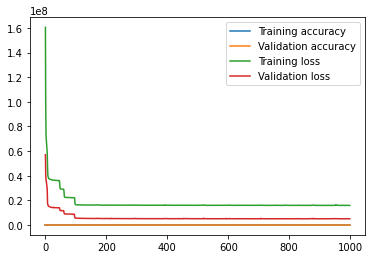

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()


# **epoch=10,000**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='LeakyReLU')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='LeakyReLU')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='LeakyReLU')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='RMSprop',
loss='mean_squared_error',
metrics=['accuracy'])


# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=10000, batch_size=None, validation_split=0.1)

Streaming output truncated to the last 5000 lines.
13/13 [==============================] - 1s 43ms/step - loss: 3495610.2500 - accuracy: 0.7875 - val_loss: 1379630.0000 - val_accuracy: 0.8121
Epoch 5439/10000
13/13 [==============================] - 1s 40ms/step - loss: 3677878.7500 - accuracy: 0.7809 - val_loss: 1351361.1250 - val_accuracy: 0.8167
Epoch 5440/10000
13/13 [==============================] - 1s 42ms/step - loss: 3489442.7500 - accuracy: 0.7861 - val_loss: 1415918.5000 - val_accuracy: 0.8231
Epoch 5441/10000
13/13 [==============================] - 1s 44ms/step - loss: 3593205.2500 - accuracy: 0.7852 - val_loss: 1363299.2500 - val_accuracy: 0.8196
Epoch 5442/10000
13/13 [==============================] - 1s 41ms/step - loss: 3555435.5000 - accuracy: 0.7832 - val_loss: 1414065.7500 - val_accuracy: 0.8127
Epoch 5443/10000
13/13 [==============================] - 1s 43ms/step - loss: 3536887.7500 - accuracy: 0.7866 - val_loss: 1375156.5000 - val_accuracy: 0.8174
Epoch 5444/1

KeyboardInterrupt: ignored

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='LeakyReLU')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='LeakyReLU')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='LeakyReLU')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='RMSprop',
loss='mean_squared_error',
metrics=['accuracy'])


# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=None, validation_split=0.1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='LeakyReLU')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='LeakyReLU')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='LeakyReLU')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='LeakyReLU')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
modelnew.compile(optimizer='RMSprop',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])


# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=None, validation_split=0.1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

upsample1 = layers.UpSampling2D(size=1)(input_layer1)

# Define the convolutional layer
conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample1)
# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='relu')(conv_layer1)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)
# Define the output layer as a convolutional layer with 31 filters
output_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(pool3)



# Define the convolutional layer
#conv_layer1 = layers.Conv2D(31, kernel_size=1, activation='relu')(input_layer1)

upsample = layers.UpSampling2D(size=8)(input_layer2)
# Define the convolutional layer
conv_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(upsample)

# Add more convolutional layers with increasing number of filters
conv4 = layers.Conv2D(64, kernel_size=1, activation='relu')(conv_layer2)
pool4 = layers.MaxPooling2D(pool_size=(1, 1))(conv4)
conv5 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool4)
pool5 = layers.MaxPooling2D(pool_size=(1, 1))(conv5)
conv6 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool5)
pool6 = layers.MaxPooling2D(pool_size=(1, 1))(conv6)
# Define the output layer as a convolutional layer with 31 filters
output_layer2 = layers.Conv2D(31, kernel_size=1, activation='relu')(pool6)

# Define the output layer
output_layer = layers.Add()([output_layer1, output_layer2 ])

# Define the model
model = tf.keras.Model([input_layer1, input_layer2], output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model and store the history object
history = model.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=None, validation_split=0.2)



Epoch 1/100
12/12 [==============================] - 26s 2s/step - loss: 1944506.6250 - accuracy: 0.0218 - val_loss: 1233010.2500 - val_accuracy: 0.0076
Epoch 2/100
12/12 [==============================] - 24s 2s/step - loss: 1375034.3750 - accuracy: 0.0138 - val_loss: 1035030.7500 - val_accuracy: 0.0356
Epoch 3/100
12/12 [==============================] - 23s 2s/step - loss: 1234819.0000 - accuracy: 0.0154 - val_loss: 1001166.9375 - val_accuracy: 0.0122
Epoch 4/100
12/12 [==============================] - 25s 2s/step - loss: 1216010.3750 - accuracy: 0.0088 - val_loss: 997207.6250 - val_accuracy: 0.0250
Epoch 5/100
12/12 [==============================] - 24s 2s/step - loss: 1211798.5000 - accuracy: 0.0257 - val_loss: 995373.5000 - val_accuracy: 0.0123
Epoch 6/100
12/12 [==============================] - 28s 2s/step - loss: 1208343.5000 - accuracy: 0.0339 - val_loss: 992857.0000 - val_accuracy: 0.0127
Epoch 7/100
12/12 [==============================] - 23s 2s/step - loss: 1205101.1250

# **model included Dropout**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='tanh')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='tanh')(combined)
dropout1 = layers.Dropout(rate=0.5)(conv1)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(dropout1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='tanh')(pool1)
dropout2 = layers.Dropout(rate=0.5)(conv2)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(dropout2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='tanh')(pool2)
dropout3 = layers.Dropout(rate=0.5)(conv3)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(dropout3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='tanh')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)
# Compile the model
modelnew.compile(optimizer='Adam',
loss='mean_absolute_error',
metrics=['accuracy'])

# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=32, validation_split=0.2)


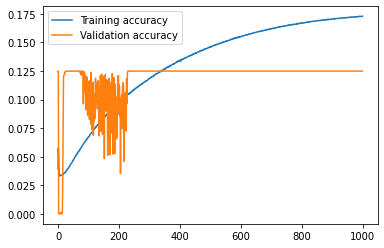

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.show()

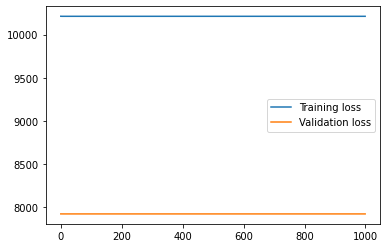

In [ ]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='ReLU')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='ReLU')(combined)
dropout1 = layers.Dropout(rate=0.5)(conv1)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(dropout1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='ReLU')(pool1)
dropout2 = layers.Dropout(rate=0.5)(conv2)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(dropout2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='ReLU')(pool2)
dropout3 = layers.Dropout(rate=0.5)(conv3)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(dropout3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='ReLU')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)
# Compile the model
modelnew.compile(optimizer='Adam',
loss='mean_squared_error',
metrics=['accuracy'])

# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=32, validation_split=0.2)


Epoch 1/1000
12/12 [==============================] - 1s 58ms/step - loss: 10211.9668 - accuracy: 0.0393 - val_loss: 7925.5103 - val_accuracy: 0.1244
Epoch 2/1000
12/12 [==============================] - 0s 39ms/step - loss: 10211.5371 - accuracy: 0.0578 - val_loss: 7925.3394 - val_accuracy: 0.1248
Epoch 3/1000
12/12 [==============================] - 0s 39ms/step - loss: 10211.3516 - accuracy: 0.0511 - val_loss: 7925.3081 - val_accuracy: 0.0010
Epoch 4/1000
12/12 [==============================] - 0s 39ms/step - loss: 10211.2842 - accuracy: 0.0403 - val_loss: 7925.3027 - val_accuracy: 0.0000e+00
Epoch 5/1000
12/12 [==============================] - 0s 38ms/step - loss: 10211.2588 - accuracy: 0.0348 - val_loss: 7925.3008 - val_accuracy: 0.0000e+00
Epoch 6/1000
12/12 [==============================] - 0s 39ms/step - loss: 10211.2490 - accuracy: 0.0336 - val_loss: 7925.2998 - val_accuracy: 0.0000e+00
Epoch 7/1000
12/12 [==============================] - 0s 38ms/step - loss: 10211.2441 - 

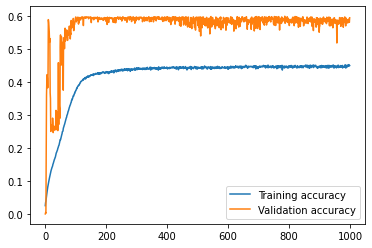

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss values
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.show()

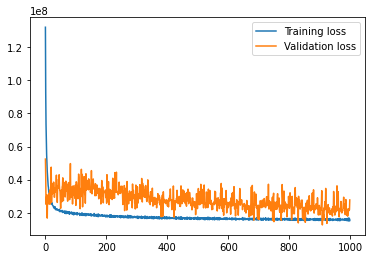

In [ ]:
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))

# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)

# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='ReLU')(upsampled)

# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='ReLU')(combined)
dropout1 = layers.Dropout(rate=0.5)(conv1)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(dropout1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='ReLU')(pool1)
dropout2 = layers.Dropout(rate=0.5)(conv2)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(dropout2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='ReLU')(pool2)
dropout3 = layers.Dropout(rate=0.5)(conv3)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(dropout3)

# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='ReLU')(pool3)

# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)
# Compile the model
modelnew.compile(optimizer='Adam',
loss='mean_absolute_error',
metrics=['accuracy'])

# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=32, validation_split=0.2)


Epoch 1/1000
12/12 [==============================] - 2s 56ms/step - loss: 7751.8071 - accuracy: 0.0187 - val_loss: 5547.4849 - val_accuracy: 0.0061
Epoch 2/1000
12/12 [==============================] - 0s 39ms/step - loss: 6781.0176 - accuracy: 0.0214 - val_loss: 5133.0098 - val_accuracy: 0.0160
Epoch 3/1000
12/12 [==============================] - 0s 39ms/step - loss: 6003.5825 - accuracy: 0.0282 - val_loss: 4451.0850 - val_accuracy: 0.0409
Epoch 4/1000
12/12 [==============================] - 0s 38ms/step - loss: 5348.4180 - accuracy: 0.0351 - val_loss: 3875.6277 - val_accuracy: 0.0518
Epoch 5/1000
12/12 [==============================] - 0s 39ms/step - loss: 4828.8794 - accuracy: 0.0459 - val_loss: 3374.0469 - val_accuracy: 0.2898
Epoch 6/1000
12/12 [==============================] - 0s 39ms/step - loss: 4448.2026 - accuracy: 0.0560 - val_loss: 3319.1768 - val_accuracy: 0.4335
Epoch 7/1000
12/12 [==============================] - 0s 39ms/step - loss: 4193.1201 - accuracy: 0.0653 - 

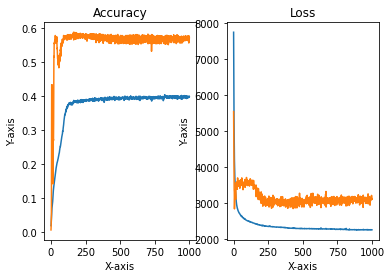

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2)
# Plot the first graph in the first subplot
ax[0].plot(acc, label='Training accuracy')
ax[0].plot(val_acc, label='Validation accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('X-axis')
ax[0].set_ylabel('Y-axis')
# Plot the second graph in the second subplot
ax[1].plot(loss, label='Training loss')
ax[1].plot(val_loss, label='Validation loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('X-axis')
ax[1].set_ylabel('Y-axis')
# Show the plot
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)
# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='ReLU')(upsampled)
# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='ReLU')(combined)
dropout1 = layers.Dropout(rate=0.5)(conv1)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(dropout1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='ReLU')(pool1)
dropout2 = layers.Dropout(rate=0.5)(conv2)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(dropout2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='ReLU')(pool2)
dropout3 = layers.Dropout(rate=0.5)(conv3)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(dropout3)
# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='ReLU')(pool3)
# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)
# Compile the model
modelnew.compile(optimizer='RMSprop',
loss='mean_absolute_error',
metrics=['accuracy'])

# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=1000, batch_size=32, validation_split=0.2)


Epoch 1/1000
12/12 [==============================] - 1s 56ms/step - loss: 7500.2891 - accuracy: 0.0314 - val_loss: 4607.3076 - val_accuracy: 0.1140
Epoch 2/1000
12/12 [==============================] - 0s 38ms/step - loss: 6120.4409 - accuracy: 0.0378 - val_loss: 4060.4534 - val_accuracy: 0.0313
Epoch 3/1000
12/12 [==============================] - 0s 39ms/step - loss: 5426.4766 - accuracy: 0.0526 - val_loss: 3190.3103 - val_accuracy: 0.1347
Epoch 4/1000
12/12 [==============================] - 0s 40ms/step - loss: 4978.9141 - accuracy: 0.0668 - val_loss: 3186.0774 - val_accuracy: 0.1827
Epoch 5/1000
12/12 [==============================] - 0s 39ms/step - loss: 4623.6162 - accuracy: 0.0767 - val_loss: 3627.6340 - val_accuracy: 0.1831
Epoch 6/1000
12/12 [==============================] - 1s 42ms/step - loss: 4349.0000 - accuracy: 0.0844 - val_loss: 3466.9084 - val_accuracy: 0.1839
Epoch 7/1000
12/12 [==============================] - 0s 39ms/step - loss: 4082.3184 - accuracy: 0.0907 - 

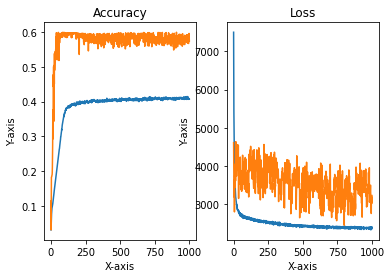

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2)
# Plot the first graph in the first subplot
ax[0].plot(acc, label='Training accuracy')
ax[0].plot(val_acc, label='Validation accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('X-axis')
ax[0].set_ylabel('Y-axis')
# Plot the second graph in the second subplot
ax[1].plot(loss, label='Training loss')
ax[1].plot(val_loss, label='Validation loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('X-axis')
ax[1].set_ylabel('Y-axis')
# Show the plot
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)
# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='ReLU')(upsampled)
# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='ReLU')(combined)
dropout1 = layers.Dropout(rate=0.5)(conv1)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(dropout1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='ReLU')(pool1)
dropout2 = layers.Dropout(rate=0.5)(conv2)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(dropout2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='ReLU')(pool2)
dropout3 = layers.Dropout(rate=0.5)(conv3)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(dropout3)
# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='ReLU')(pool3)
# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)
# Compile the model
modelnew.compile(optimizer='RMSprop',
loss='mean_absolute_error',
metrics=['accuracy'])

# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=5000, batch_size=32, validation_split=0.2)


Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 1s 46ms/step - loss: 2292.4639 - accuracy: 0.4097 - val_loss: 2530.7576 - val_accuracy: 0.5756
Epoch 2502/5000
12/12 [==============================] - 1s 43ms/step - loss: 2312.2212 - accuracy: 0.4144 - val_loss: 2982.5166 - val_accuracy: 0.5823
Epoch 2503/5000
12/12 [==============================] - 1s 43ms/step - loss: 2334.4536 - accuracy: 0.4089 - val_loss: 2707.8850 - val_accuracy: 0.5570
Epoch 2504/5000
12/12 [==============================] - 1s 43ms/step - loss: 2321.2156 - accuracy: 0.4064 - val_loss: 2856.0146 - val_accuracy: 0.5826
Epoch 2505/5000
12/12 [==============================] - 1s 42ms/step - loss: 2334.5051 - accuracy: 0.4108 - val_loss: 3005.4333 - val_accuracy: 0.5837
Epoch 2506/5000
12/12 [==============================] - 1s 45ms/step - loss: 2313.6301 - accuracy: 0.4116 - val_loss: 2909.1763 - val_accuracy: 0.5630
Epoch 2507/5000
12/12 [==============================

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2)
# Plot the first graph in the first subplot
ax[0].plot(acc, label='Training accuracy')
ax[0].plot(val_acc, label='Validation accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('X-axis')
ax[0].set_ylabel('Y-axis')
ax[0].set_legend()
# Plot the second graph in the second subplot
ax[1].plot(loss, label='Training loss')
ax[1].plot(val_loss, label='Validation loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('X-axis')
ax[1].set_ylabel('Y-axis')
# Show the plot
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define the input layers
input_layer1 = layers.Input(shape=(64, 64, 3))
input_layer2 = layers.Input(shape=(8, 8, 31))
# Upsample the second input image
upsampled = layers.UpSampling2D(size=8)(input_layer2)
# Combine the two input images using a convolutional layer
combined = layers.Conv2D(31, kernel_size=1, activation='relu')(upsampled)
# Add more convolutional layers with increasing number of filters
conv1 = layers.Conv2D(64, kernel_size=1, activation='relu')(combined)
pool1 = layers.MaxPooling2D(pool_size=(1, 1))(conv1)
conv2 = layers.Conv2D(128, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(1, 1))(conv2)
conv3 = layers.Conv2D(64, kernel_size=1, activation='relu')(pool2)
pool3 = layers.MaxPooling2D(pool_size=(1, 1))(conv3)
# Define the output layer as a convolutional layer with 31 filters
output_layer = layers.Conv2D(31, kernel_size=1, activation='relu')(pool3)
# Define the model
modelnew = tf.keras.Model([input_layer1, input_layer2], output_layer)
# Compile the model
modelnew.compile(optimizer='adam',
loss='mean_absolute_error',
metrics=['accuracy'])
# Train the model and store the history object
history = modelnew.fit([HR_RGB, LRHSI], image_transposed, epochs=5000, batch_size=None, validation_split=0.1)

Streaming output truncated to the last 5000 lines.
13/13 [==============================] - 0s 35ms/step - loss: 702.4299 - accuracy: 0.7847 - val_loss: 488.5335 - val_accuracy: 0.8364
Epoch 2502/5000
13/13 [==============================] - 0s 34ms/step - loss: 695.5551 - accuracy: 0.7856 - val_loss: 466.0029 - val_accuracy: 0.8379
Epoch 2503/5000
13/13 [==============================] - 0s 36ms/step - loss: 691.2009 - accuracy: 0.7874 - val_loss: 455.2627 - val_accuracy: 0.8389
Epoch 2504/5000
13/13 [==============================] - 0s 35ms/step - loss: 687.2512 - accuracy: 0.7853 - val_loss: 455.9189 - val_accuracy: 0.8390
Epoch 2505/5000
13/13 [==============================] - 0s 36ms/step - loss: 683.2646 - accuracy: 0.7844 - val_loss: 453.1620 - val_accuracy: 0.8365
Epoch 2506/5000
13/13 [==============================] - 0s 35ms/step - loss: 680.7909 - accuracy: 0.7862 - val_loss: 453.4742 - val_accuracy: 0.8388
Epoch 2507/5000
13/13 [==============================] - 0s 36ms/

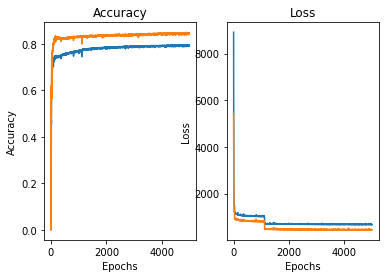

In [ ]:
# Extract the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2)
# Plot the first graph in the first subplot
ax[0].plot(acc, label='Training accuracy')
ax[0].plot(val_acc, label='Validation accuracy')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Plot the second graph in the second subplot
ax[1].plot(loss, label='Training loss')
ax[1].plot(val_loss, label='Validation loss')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

# Show the plot
plt.show()